In [1]:
import pandas as pd
import Experiment_calculus as exca
import Experiment_FDA as exda

# Adjust pandas options to see all columns and to read subgroup descriptions fully
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

In [2]:
exda.main(test_size=0.3, min_size=70) 

Collected 50 subgroup models.
Exported 50 subgroup models to Results/subgroup_linear_fda.csv
Complex baseline evaluation metrics: {'r2': 0.2448, 'mae': np.float64(0.896), 'mse': np.float64(1.3318), 'mean_residual': -0.0507, 'y_pred': 413    7.190687
955    7.511497
601    7.117113
593    4.713580
816    7.702503
         ...   
282    6.540978
822    6.108500
880    6.707639
50     3.850318
701    7.530131
Length: 300, dtype: float64}


In [3]:
df_s = pd.read_csv("results/subgroup_results_fda.csv")
df_s = df_s[:50]
df_s.head(1)
#df_s.columns

,r2,mae,mse,mean_residual,intercept,coef__total_attended_labsessions,pval__total_attended_labsessions,coef__active_minutes,pval__active_minutes,coef__nr_distinct_files_viewed,pval__nr_distinct_files_viewed,coef__total_course_activities,pval__total_course_activities,coef__distinct_days,pval__distinct_days,coef__nr_files_viewed,pval__nr_files_viewed,coef__nr_practice_exams_viewed,pval__nr_practice_exams_viewed,model_type,description,cookD,n_train,n_test,global_baseline_r2,global_baseline_mae,global_baseline_mse,global_baseline_mean_residual,mean_baseline_r2,mean_baseline_mae,mean_baseline_mse,mean_baseline_mean_residual,ttest_p,ttest_stat,wilcoxon_p,wilcoxon_stat,ttest_p_mean,ttest_stat_mean,wilcoxon_p_mean,wilcoxon_stat_mean,ttest_p_mean_global,ttest_stat_mean_global,wilcoxon_p_mean_global,wilcoxon_stat_mean_global
0,-0.0196,0.6214,0.6042,-0.2071,7.047028,0.04974,0.048857,0.00002,0.39813,0.041676,0.134913,-0.001005,0.840581,0.017291,0.34095,-0.006436,0.755922,0.005539,0.824891,subgroup,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ type_vooropleiding=='BUITENL_SL'",106.30051,98,49,-0.9014,0.8899,1.1267,0.7628,-0.107203,0.633215,0.656086,-0.252041,0.017418,-2.171887,0.005644,360.0,0.124703,-1.165922,0.314438,563.0,0.958827,1.77436,0.993455,859.0


In [4]:
# Assign rank: one per row (since you now have only subgroup_model rows)
df_s['subgroup_rank'] = (df_s.index + 1).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_rank'] = "N/A"

# Round columns for better readability
for col, ndigits in [('cookD', 2), ('r2', 3), ('mae', 3), ('mse', 3), ('mean_residual', 3),
                     ('global_baseline_r2', 3), ('global_baseline_mae', 3), ('global_baseline_mse', 3), ('global_baseline_mean_residual', 3),
                     ('mean_baseline_r2', 3), ('mean_baseline_mae', 3), ('mean_baseline_mse', 3), ('mean_baseline_mean_residual', 3)]:
    if col in df_s.columns:
        df_s[col] = df_s[col].round(ndigits)

# Compare r2 between subgroup_model and global baseline for each row
df_s['subgroup_r2_better'] = (df_s['r2'] > df_s['global_baseline_r2']).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_r2_better'] = None
df_s['subgroup_better_global'] = (df_s['ttest_p'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
df_s['subgroup_better_mean'] = (df_s['ttest_p_mean'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
df_s['global_better_mean'] = (df_s['ttest_p_mean_global'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'global_better_mean'] = None

# Add decision column based on the rules
def determine_decision(row):
    sg = row['subgroup_better_global']
    sm = row['subgroup_better_mean']
    gm = row['global_better_mean']
    
    if sg and sm:
        return "True discovery"
    elif sg and not sm:
        return "True discovery, but model not appropriate"
    elif not sg and sm:
        return "Weak discovery"
    elif not sg and not sm and gm:
        return "False discovery"
    else:
        return "Model not appropriate"

df_s['decision'] = df_s.apply(determine_decision, axis=1)

# Specify desired column order
main_cols = [
    'subgroup_rank', 'model_type', 'description', 'decision', 'subgroup_r2_better', 'cookD', 'n_train', 'n_test',
    'r2', 'global_baseline_r2', 'mean_baseline_r2', 
    'mae', 'global_baseline_mae', 'mean_baseline_mae',
    'mse', 'global_baseline_mse', 'mean_baseline_mse',
    'mean_residual', 'global_baseline_mean_residual', 'mean_baseline_mean_residual'
]
rest_cols = [c for c in df_s.columns if c not in main_cols]
new_order = main_cols + rest_cols

# Reorder columns
df_s = df_s[new_order]

/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38319/2205722591.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38319/2205722591.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38319/2205722591.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [5]:
df_s[df_s['decision'].isin(['True discovery'])][['subgroup_rank', 'description', 'decision', 'n_test', 'n_train', 'cookD', 'r2', 'global_baseline_r2', 'mean_baseline_r2']]

,subgroup_rank,description,decision,n_test,n_train,cookD,r2,global_baseline_r2,mean_baseline_r2
5,6,"ECTS=='15' ∧ GPA in (7.0, 8.9]",True discovery,60,125,103.02,0.068,-0.865,-0.085
6,7,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ course_repeater==np.False_",True discovery,60,125,103.02,0.068,-0.865,-0.085
7,8,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ double_major==np.False_",True discovery,60,125,103.02,0.068,-0.865,-0.085
8,9,"GPA in (7.0, 8.9] ∧ type_vooropleiding=='BUITENL_SL'",True discovery,55,111,101.92,0.003,-0.751,-0.113
9,10,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_ ∧ type_vooropleiding=='BUITENL_SL'",True discovery,55,111,101.92,0.003,-0.751,-0.113
10,11,"GPA in (7.0, 8.9] ∧ double_major==np.False_ ∧ type_vooropleiding=='BUITENL_SL'",True discovery,55,111,101.92,0.003,-0.751,-0.113
11,12,"GPA in (7.0, 8.9]",True discovery,72,160,100.41,0.009,-0.780,-0.132
12,13,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_",True discovery,72,160,100.41,0.009,-0.780,-0.132
13,14,"GPA in (7.0, 8.9] ∧ double_major==np.False_",True discovery,72,160,100.41,0.009,-0.780,-0.132
14,15,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_ ∧ double_major==np.False_",True discovery,72,160,100.41,0.009,-0.780,-0.132


In [6]:
df_s[(df_s['decision'].isin(['Model not appropriate', 'Weak discovery'])) & ( df_s['r2'] > 0) & ( df_s['r2'] > df_s['global_baseline_r2'])][['subgroup_rank', 'description', 'decision', 'n_test', 'cookD','r2', 'global_baseline_r2', 'mean_baseline_r2']]

,subgroup_rank,description,decision,n_test,cookD,r2,global_baseline_r2,mean_baseline_r2
33,34,"GPA in (1.399, 5.6] ∧ origin=='ORIGIN_N' ∧ type_vooropleiding=='VWO'",Model not appropriate,26,70.58,0.435,0.259,-0.007
34,35,"GPA in (1.399, 5.6] ∧ type_vooropleiding=='VWO'",Model not appropriate,27,70.51,0.444,0.281,-0.004
35,36,"GPA in (1.399, 5.6] ∧ double_major==np.False_ ∧ type_vooropleiding=='VWO'",Model not appropriate,27,70.51,0.444,0.281,-0.004
43,44,"GPA in (1.399, 5.6] ∧ origin=='ORIGIN_N'",Model not appropriate,33,62.81,0.382,0.110,-0.007
44,45,"GPA in (1.399, 5.6] ∧ double_major==np.False_ ∧ origin=='ORIGIN_N'",Model not appropriate,33,62.81,0.382,0.110,-0.007


In [7]:
df_s['decision'].value_counts()

decision
True discovery                               28
True discovery, but model not appropriate    13
Model not appropriate                         9
Name: count, dtype: int64

In [18]:
df = pd.read_csv('results/coefs_fda.csv')

# Create display labels: #1, #2, ...
chosen = [ 16, 18, 28, 30, 37, 39, 41, 42]# 6, 9, 12,21, 27


df_lins = df[df['subgroup'].isin(['#'+str(i) for i in chosen] + ['Ω'])]

df_lins = df_lins[df_lins['term'] != 'const']

df_s[df_s['subgroup_rank'].isin(chosen )][['subgroup_rank', 'description', 'decision', 'cookD', 'r2', 'global_baseline_r2', 'n_test']]

,subgroup_rank,description,decision,cookD,r2,global_baseline_r2,n_test
15,16,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ sex=='SEX_M'",True discovery,100.05,0.125,-1.461,38
17,18,"GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E'",True discovery,97.58,0.174,-1.186,37
27,28,"GPA in (1.399, 5.6] ∧ croho=='B Industrial Engineering'",True discovery,82.43,0.448,-0.331,32
29,30,"GPA in (1.399, 5.6] ∧ course_repeater==np.False_ ∧ croho=='B Industrial Engineering'",True discovery,81.98,0.470,-0.496,30
36,37,"GPA in (1.399, 5.6] ∧ sex=='SEX_M'",True discovery,66.93,0.408,-0.076,59
38,39,"GPA in (1.399, 5.6] ∧ course_repeater==np.False_",True discovery,66.59,0.340,-0.331,65
40,41,"GPA in (1.399, 5.6] ∧ course_repeater==np.False_ ∧ sex=='SEX_M'",True discovery,66.16,0.424,-0.225,51
41,42,"GPA in (1.399, 5.6]",True discovery,64.26,0.345,-0.170,75


63 70


/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38319/2675758831.py:19: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  ax = sns.barplot(


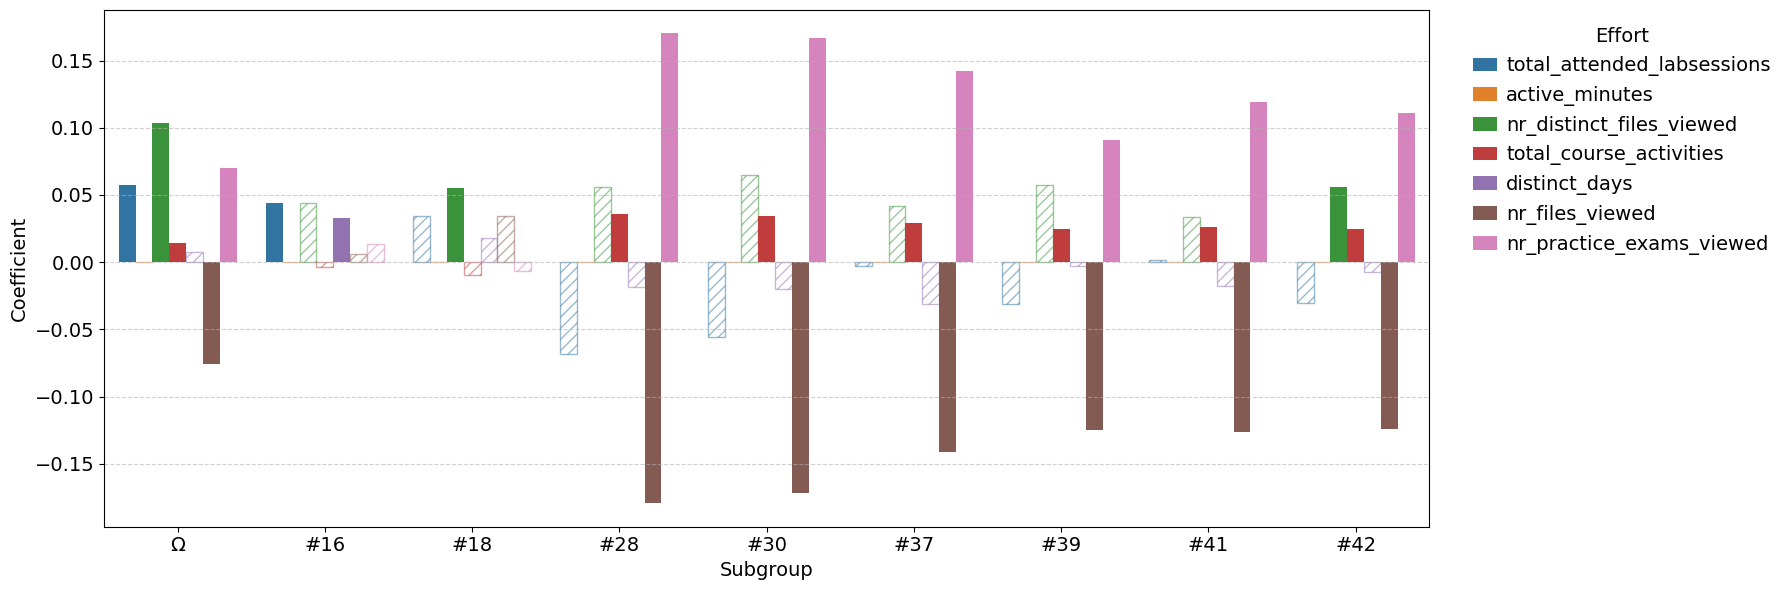

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from matplotlib.patches import Patch


#####
# To DO: Change bar fill depending on significant, yes or no 
#####

palette = sns.color_palette("tab10", 16)
#palette = random.shuffle(palette)
plt.figure(figsize=(18, 6))

df = df_lins#[ df_all['term'] != 'Intercept']

ax = sns.barplot(
    data=df,
    x="subgroup",
    y="coef",
    hue="term",
    dodge=True,
    palette=palette
)
patches_sorted = sorted(ax.patches[:-7], key=lambda p: p.get_x())
print(len(df_lins['significant']), len(ax.patches))
for patch, sig in zip(patches_sorted, df_lins['significant']):
    if sig == 'no':
        patch.set_hatch("///")      # striped fill
        patch.set_edgecolor(patch.get_facecolor())  # keep original color for stripes
        patch.set_facecolor("white")  # base color for hatch
        patch.set_alpha(0.5)
#     # sig == 1 → leave as solid color

ax.set_xlabel("Subgroup", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)

# Grid (clean style)how 
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.grid(False)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

# # Legend outside
# # Smaller legend outside the plot
ax.legend(

    title="Effort",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=14,          # legend text size
    title_fontsize=14,    # legend title size
    frameon=False,       # cleaner look
    handlelength=1.2,
    handletextpad=0.5
)
# Custom legend
# Color legend for terms
terms = df_lins["term"].unique()
palette = sns.color_palette("tab10", len(terms))
color_handles = [Patch(facecolor=palette[i], label=term) for i, term in enumerate(terms)]

# # # Hatch legend for significance
sig_handles = [
    Patch(facecolor="white", edgecolor="black", hatch="///", label="not significant"),
    Patch(facecolor="black", edgecolor="black", label="significant")
]

# Combine legends first_legend = ax.legend(handles=color_handles, title="Term", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, title_fontsize=9) ax.add_artist(first_legend) ax.legend(handles=sig_handles, title="Significance", bbox_to_anchor=(1.02, 0.6), loc="upper left", fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()